### 0. The Goal
A fitness studio called based in Singapore is interested in understanding the types of digital products they should offer. 
They have asked me to perform analysis that will help them 
- understand how to place their digital fitness products in the regional market, 
- identify strengths of their competitors, 
- gauge demand, and 
- create unique new digital products and services for potential users.

To accomplish this, I will conduct a market analysis in Python using international data on Google Trends and YouTube keyword searches related to fitness and related products. International data is provided to me by the fitness studio.

### 1. DATA VALIDATION
Sub-goal: Assess data quality and perform validation tasks:
1. Describe validation and cleaning steps for every column/variable in the data
2. Result in an analysis-ready data (or clearly documented reasons for not being able to do so.)


I start by assessing global demand for working out. To do this, I will create and call helper functions "read_file" and "read_geo" to load the workout.csv file into a DataFrame.

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white', palette='Pastel2')
import os

def read_file(filepath, plot = True):
    """
    Read a CSV file from a given filepath, convert it into a DataFrame, and return a
    processed DataFrame with three columns: 'week', 'region', and 'interest'. 
    Generate a line plot using Seaborn to visualize the data. 
    This corresponds to the first graphic (time series) returned by trends.google.com. 
    """
    if not hasattr(read_file, "count"): # if the function has not been called before, set the count to 1
        read_file.count = 1
    else: # if the function has been called before, increment the count by 1
        read_file.count += 1

    file = pd.read_csv(filepath, header=1)
    df = file.set_index('Week').stack().reset_index()
    df.columns = ['week','region','interest']
    df['week'] = pd.to_datetime(df['week'])
    plt.figure(figsize=(8,3))
    df = df[df['interest']!="<1"]
    df['interest'] = df['interest'].astype(float)

    if plot: # modify the code so it gives the plot a title "Figure [n]: workout interest over time". n is how many times the function has been called.
        plt.title(f"Figure {read_file.count}: Google Trends search ratio over time")
        sns.lineplot(data = df, x= 'week', y= 'interest', hue='region')
    return df

def read_geo(filepath, multi=False):
    """
    Read a CSV file from a given filepath, convert it into a pandas DataFrame,
    and return a processed DataFrame with two columns: 'country' and 'interest'. 
    Generate a bar plot using Seaborn to visualize the data. 
    This corresponds to the second graphic returned by trends.google.com. 
    Use multi=False if only one keyword is being analyzed, and 
    multi=True if more than one keyword is being analyzed.
    """
    file = pd.read_csv(filepath, header=1)

    if not multi:
        file.columns = ['country', 'interest']
        plt.figure(figsize=(8,4))
        sns.barplot(data = file.dropna().iloc[:25,:], y = 'country', x='interest')

    if multi:
        plt.figure(figsize=(3,8))
        file = file.set_index('Country').stack().reset_index()
        file.columns = ['country','category','interest']
        file['interest'] = pd.to_numeric(file['interest'].apply(lambda x: x[:-1]))
        sns.barplot(data=file.dropna(), y = 'country', x='interest', hue='category')

    file = file.sort_values(ascending=False,by='interest')
    return file

First, I'll use pandas and other coding methods to assess the month in which demand for fitness is highest across the world, on average.

In [13]:
import pandas as pd
df = pd.read_csv('workout.csv')
dataset_name = 'workout.csv'
df

,Category: All categories
Week,workout: (Worldwide)
2018-03-18,59
2018-03-25,58
2018-04-01,61
2018-04-08,57
...,...
2023-02-12,52
2023-02-19,55
2023-02-26,60
2023-03-05,55


,week,region,interest
0,2018-03-18,workout: (Worldwide),59.0
1,2018-03-25,workout: (Worldwide),58.0
2,2018-04-01,workout: (Worldwide),61.0
3,2018-04-08,workout: (Worldwide),57.0
4,2018-04-15,workout: (Worldwide),59.0
...,...,...,...
256,2023-02-12,workout: (Worldwide),52.0
257,2023-02-19,workout: (Worldwide),55.0
258,2023-02-26,workout: (Worldwide),60.0
259,2023-03-05,workout: (Worldwide),55.0


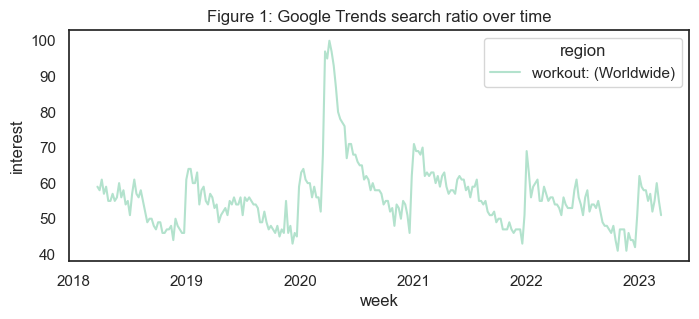

In [14]:
df = read_file('workout.csv')
df

From figure 1, we can see that demand is cyclical, with peaks in January. This is likely due to New Year's resolutions. The lowest demand is in December, which is likely due to the holiday season. We can also see outlier event peaks in March 2020, which is likely due to the COVID-19 pandemic as people were forced to stay home and were using Google Search to find ways to exercise.

In [15]:
# Use your workout variable to assess in which month demand for fitness is highest across the world, on average.
# Call set_index() on this DataFrame with "week" as the first argument, and then chain this with a .resample(), with the argument 'MS' (for month) as the first argument. 
# Then, similar to what you do with a groupby(), chain this with a .mean() to obtain means by month and save it to a new object workout_by_month.
# Return a row called month_high containing the month with the highest activity from this workout_by_month. 
# The index of the month_high DataFrame is a Timestamp, and you can access its date portion using the .date()function.

workout = read_file('workout.csv', plot=False)
workout = workout.set_index('week').resample('MS').mean()
workout_by_month = workout.mean(axis=1)
print(workout_by_month.sort_values(ascending=False))
month_high = workout_by_month.idxmax().date()
month_high

week
2020-04-01    94.25
2020-05-01    75.60
2020-03-01    73.60
2020-06-01    69.50
2021-01-01    69.40
              ...  
2018-10-01    47.00
2019-10-01    46.50
2022-11-01    45.25
2022-12-01    45.25
2022-10-01    45.20
Length: 61, dtype: float64


C:\Users\Coachilla 1\AppData\Local\Temp\ipykernel_2720\346917044.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  workout = workout.set_index('week').resample('MS').mean()


datetime.date(2020, 4, 1)

<Figure size 800x300 with 0 Axes>

In [16]:
import pandas as pd
import scipy.stats as stats

def generate_report(df, dataset_name):
    num_duplicate_rows = df.duplicated().sum()
    report = f"The dataset in {dataset_name} has {df.shape[0]} rows "
    if num_duplicate_rows == 0:
        report += "from which 0 are duplicates."
    else:
        report += f"from which {num_duplicate_rows} are duplicates.\n"
    
    report += "\n\nThe Data is observed via {} columns:\n".format(df.shape[1])
    
    for column in df.columns:
        report += get_column_info(df, column)
    
    report += additional_data_validation_tasks(df)
    
    return report

def get_column_info(df, column_name):
    num_unique_values = df[column_name].nunique()
    num_missing_values = df[column_name].isnull().sum()
    
    missing_status = f"and {num_missing_values} missing values."
    
    info = f"- {column_name}: Contained {num_unique_values} unique values {missing_status}\n"
    
    return info

def additional_data_validation_tasks(df):
    # Outlier Detection Task
    outlier_status = detect_outliers(df)

    # Skewness and Kurtosis Task
    skewness_kurtosis_status = calculate_skewness_kurtosis(df)
    
    return outlier_status + skewness_kurtosis_status

def detect_outliers(df):
    # You can implement your outlier detection logic here.
    # For example, identify and report columns with potential outliers.
    
    # Placeholder logic for illustration purposes
    outlier_columns = [col for col in df.columns if df[col].dtype == 'float64']
    outlier_status = f"\nThe following columns contained outliers: {', '.join(outlier_columns)}\n"
    
    return outlier_status

def calculate_skewness_kurtosis(df):
    skewness_kurtosis_status = ""
    for col in df.select_dtypes(include=['float64']).columns:
        skewness = stats.skew(df[col].dropna())
        kurtosis = stats.kurtosis(df[col].dropna())
        skewness_kurtosis_status += f"{col}: Skewness = {skewness:.2f}, Kurtosis = {kurtosis:.2f}\n"
    return skewness_kurtosis_status

# Call the generate_report function to generate the report
report_text = generate_report(df, dataset_name)

# Print the report
print(report_text)


The dataset in workout.csv has 261 rows from which 0 are duplicates.

The Data is observed via 3 columns:
- week: Contained 261 unique values and 0 missing values.
- region: Contained 1 unique values and 0 missing values.
- interest: Contained 40 unique values and 0 missing values.

The following columns contained outliers: interest
interest: Skewness = 1.98, Kurtosis = 6.49



The outlier values of interest seen in figure 1 in raise its kurtosis value to 6.49, which is significantly greater than the desired 3. This indicates that the data is not normally distributed, which is needed for statistical tests and predictions. I will address this when it is required.

,week,region,interest
0,2018-03-18,home workout: (Worldwide),12.0
1,2018-03-18,gym workout: (Worldwide),16.0
2,2018-03-18,home gym: (Worldwide),10.0
3,2018-03-25,home workout: (Worldwide),13.0
4,2018-03-25,gym workout: (Worldwide),17.0
...,...,...,...
778,2023-03-05,gym workout: (Worldwide),19.0
779,2023-03-05,home gym: (Worldwide),12.0
780,2023-03-12,home workout: (Worldwide),14.0
781,2023-03-12,gym workout: (Worldwide),18.0


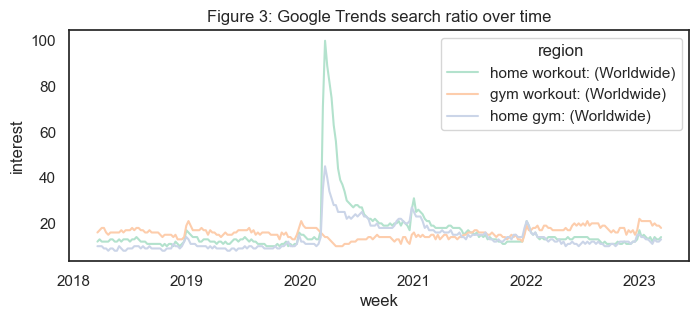

In [17]:
keywords = read_file('three_keywords.csv')
keywords

In [18]:
# current = the keyword string value that you can see generated the most interest from "week" that has the year "2022" and "2023".
current = keywords[(keywords['week'] >= '2022-01-01')].groupby('region').mean().sort_values(by='interest', ascending=False)
current

C:\Users\Coachilla 1\AppData\Local\Temp\ipykernel_2720\2464642269.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  current = keywords[(keywords['week'] >= '2022-01-01')].groupby('region').mean().sort_values(by='interest', ascending=False)


,interest
region,
gym workout: (Worldwide),18.333333
home workout: (Worldwide),13.285714
home gym: (Worldwide),12.396825


Gym workouts gained the most interest in 2022 and 2023.

In [19]:
# 2. peak_covid, indicating which keyword string value that you can see generated the most interest during 2020.
peak_covid = keywords[(keywords['week'] >= '2020-01-01') & (keywords['week'] < '2021-01-01')].groupby('region').mean().sort_values(by='interest', ascending=False)
peak_covid

C:\Users\Coachilla 1\AppData\Local\Temp\ipykernel_2720\2558621798.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  peak_covid = keywords[(keywords['week'] >= '2020-01-01') & (keywords['week'] < '2021-01-01')].groupby('region').mean().sort_values(by='interest', ascending=False)


,interest
region,
home workout: (Worldwide),29.384615
home gym: (Worldwide),21.250000
gym workout: (Worldwide),13.769231


During 2020, the COVID-19 pandemic caused a spike in interest in home workouts.

,country,interest
5,United States,100.0
12,Canada,86.0
18,Australia,77.0
22,New Zealand,73.0
23,Lebanon,73.0
30,Ireland,69.0
31,Philippines,69.0
35,Singapore,66.0
36,United Kingdom,66.0
47,United Arab Emirates,56.0


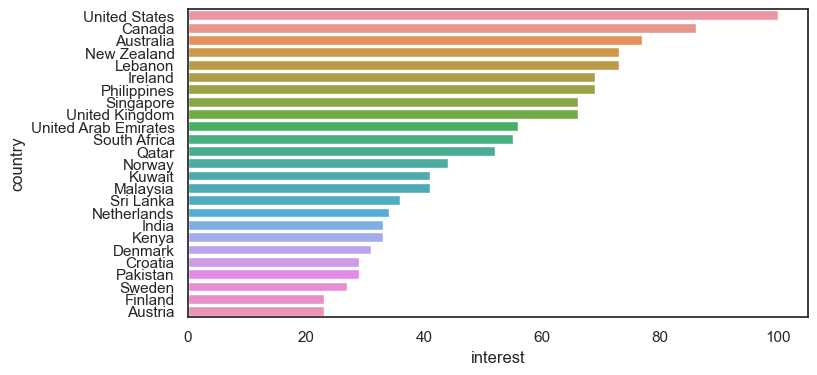

In [20]:
# Disaggregate global demand in the "workout" keyword by region to find the top 25 countries with the highest interest in workouts. 
# Read workout_global.csv into a DataFrame, using the "read_geo" function. Note that the helper function sorts the values in the DataFrame it returns.
workout_global = read_geo('workout_global.csv')
workout_global.head(10)

In [21]:
top_25_countries = workout_global.iloc[:25,:]
print(top_25_countries)
# Use pandas code to create a variable top_country with a string value for the name of the country with the highest interest in workouts.
top_country = top_25_countries.iloc[0,0]
top_country

                  country  interest
5           United States     100.0
12                 Canada      86.0
18              Australia      77.0
22            New Zealand      73.0
23                Lebanon      73.0
30                Ireland      69.0
31            Philippines      69.0
35              Singapore      66.0
36         United Kingdom      66.0
47   United Arab Emirates      56.0
50           South Africa      55.0
53                  Qatar      52.0
68                 Norway      44.0
70                 Kuwait      41.0
72               Malaysia      41.0
79              Sri Lanka      36.0
80            Netherlands      34.0
83                  India      33.0
84                  Kenya      33.0
87                Denmark      31.0
90                Croatia      29.0
91               Pakistan      29.0
92                 Sweden      27.0
102               Finland      23.0
103               Austria      23.0


'United States'

,country,category,interest
102,Iran,home workout: (3/16/18 - 3/16/23),58
45,Nigeria,home workout: (3/16/18 - 3/16/23),56
9,Philippines,home workout: (3/16/18 - 3/16/23),52
66,Switzerland,home workout: (3/16/18 - 3/16/23),52
123,Turkey,home workout: (3/16/18 - 3/16/23),52


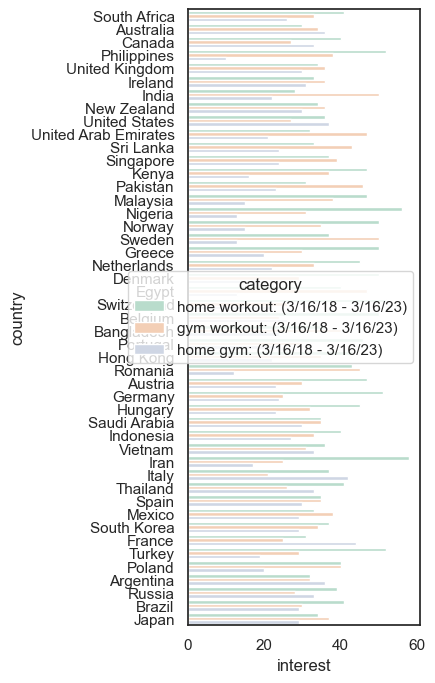

In [22]:
# Use the "read_geo" function with the file geo_three_keywords.csv to load its geographic data, and save it as geo_categories.
geo_categories = read_geo('geo_three_keywords.csv', multi=True)
geo_categories.head()

In [23]:
geo_categories = geo_categories.set_index(['country','category']).unstack()
geo_categories.columns = ['home workout', 'gym workout', 'workout']
geo_categories.head()

,home workout,gym workout,workout
country,,,
Argentina,32,36,32
Australia,34,36,30
Austria,30,23,47
Bangladesh,40,24,36
Belgium,24,26,50


In [24]:
# Middle East and South Asia are in the top 25 countries with interest in workouts, including "Philippines", "Singapore", "United Arab Emirates," "Qatar," "Kuwait," "Lebanon," "Malaysia," "Sri Lanka," "India," and "Pakistan."
# Filter geo_categories to return only these countries and save this as a DataFrame MESA.
MESA = geo_categories[geo_categories.index.isin(['Philippines', 'Singapore', 'United Arab Emirates', 'Qatar', 'Kuwait', 'Lebanon', 'Malaysia', 'Sri Lanka', 'India', 'Pakistan'])]
MESA.head()

,home workout,gym workout,workout
country,,,
India,50,22,28
Malaysia,38,15,47
Pakistan,46,23,31
Philippines,38,10,52
Singapore,39,24,37


In [25]:
# Create a table of this data using pandas to visually identify the country with the highest interest in home workouts, and save it as a string to a variable top_home_workout_country.
top_home_workout_country = MESA.sort_values(ascending=False, by='home workout')
print(top_home_workout_country)
top_home_workout_country = top_home_workout_country.iloc[0,:].name
top_home_workout_country

                      home workout  gym workout  workout
country                                                 
India                           50           22       28
United Arab Emirates            47           21       32
Pakistan                        46           23       31
Sri Lanka                       43           24       33
Singapore                       39           24       37
Malaysia                        38           15       47
Philippines                     38           10       52


'India'

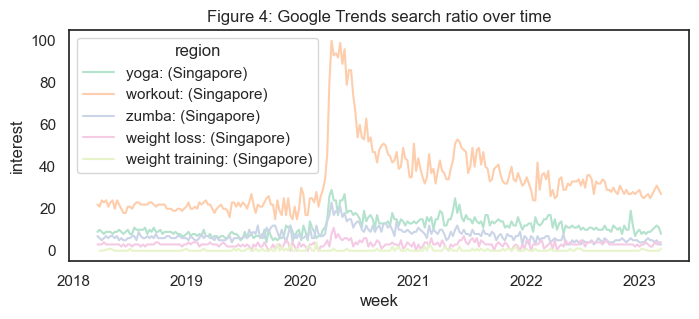

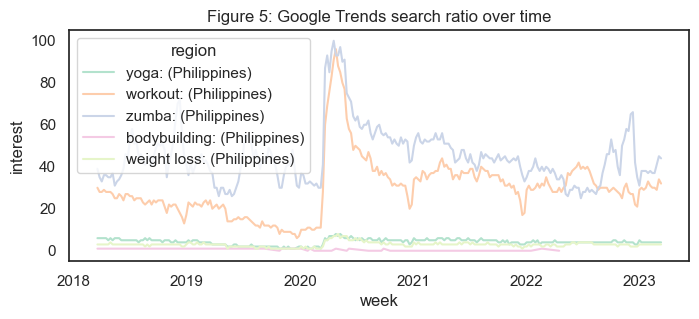

In [26]:
# I'll look at YouTube keyword searches next. Use a read_geo to read files data/yoga_zumba_sng.csv and data/yoga_zumba_phl.csv, to compare data for Singapore and Philippines respectively.
sng = read_file('yoga_zumba_sng.csv')
phl = read_file('yoga_zumba_phl.csv')

In [27]:
sng.head()

,week,region,interest
0,2018-03-18,yoga: (Singapore),9.0
1,2018-03-18,workout: (Singapore),22.0
2,2018-03-18,zumba: (Singapore),7.0
4,2018-03-18,weight loss: (Singapore),3.0
5,2018-03-25,yoga: (Singapore),10.0


In [45]:
# regard only weeks before 2020 and after 2022, and save this as a DataFrame current_sng.
current_sng = sng[(sng['week'] < '2020-01-01') | (sng['week'] >= '2022-01-01')]
# add another column to the DataFrame current_sng called 'country' and fill it with the string 'Singapore'.
current_sng['country'] = 'Singapore'
# take out the ": (Singapore)" part from region values in the DataFrame current_sng.
current_sng['region'] = current_sng['region'].str.replace(': \(Singapore\)', '')
# make an individual column for each unique value in 'region' and fill it with the values in 'interest'.
current_sng = current_sng.pivot(index=['week', 'country'], columns='region', values='interest')
# delete column header 'region'
current_sng.columns.name = None
# reset the index of current_sng.
current_sng = current_sng.reset_index()
# drop columns 'weight_loss', 'workout' from current_sng.
current_sng = current_sng.drop(columns=['weight loss', 'workout', 'weight training'])

current_sng.head()

C:\Users\Coachilla 1\AppData\Local\Temp\ipykernel_2720\2623036142.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_sng['country'] = 'Singapore'
C:\Users\Coachilla 1\AppData\Local\Temp\ipykernel_2720\2623036142.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  current_sng['region'] = current_sng['region'].str.replace(': \(Singapore\)', '')
C:\Users\Coachilla 1\AppData\Local\Temp\ipykernel_2720\2623036142.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

,week,country,yoga,zumba
0,2018-03-18,Singapore,9.0,7.0
1,2018-03-25,Singapore,10.0,6.0
2,2018-04-01,Singapore,9.0,5.0
3,2018-04-08,Singapore,8.0,6.0
4,2018-04-15,Singapore,9.0,7.0


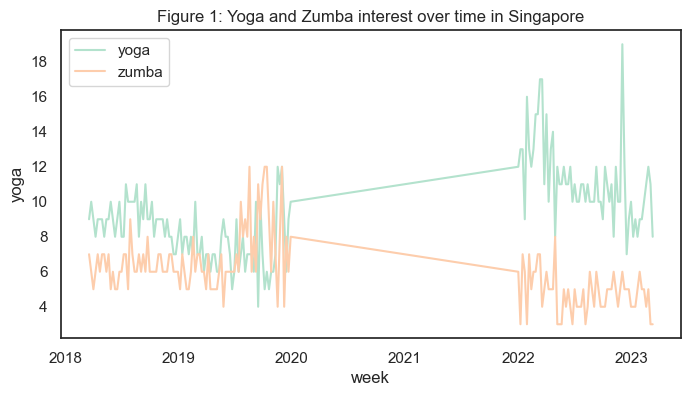

In [46]:
# plot a line plot using Seaborn to visualize the data in current_sng.
plt.figure(figsize=(8,4))
sns.lineplot(data=current_sng, x='week', y='yoga', label='yoga')
sns.lineplot(data=current_sng, x='week', y='zumba', label='zumba')
plt.title('Figure 1: Yoga and Zumba interest over time in Singapore')
plt.show()

In [42]:
# repeat the same steps for the DataFrame phl.
current_phl = phl[(phl['week'] < '2020-01-01') | (sng['week'] >= '2022-01-01')]
current_phl['country'] = 'Philippines'
current_phl['region'] = current_phl['region'].str.replace(': \(Philippines\)', '')
current_phl = current_phl.pivot(index=['week', 'country'], columns='region', values='interest')
current_phl.columns.name = None
current_phl = current_phl.reset_index()
current_phl = current_phl.drop(columns=['weight loss', 'workout', 'bodybuilding'])

current_phl.head()


C:\Users\Coachilla 1\AppData\Local\Temp\ipykernel_2720\3565267149.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_phl['country'] = 'Philippines'
C:\Users\Coachilla 1\AppData\Local\Temp\ipykernel_2720\3565267149.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  current_phl['region'] = current_phl['region'].str.replace(': \(Philippines\)', '')
C:\Users\Coachilla 1\AppData\Local\Temp\ipykernel_2720\3565267149.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

,week,country,yoga,zumba
0,2022-01-02,Philippines,4.0,35.0
1,2022-01-09,Philippines,4.0,38.0
2,2022-01-16,Philippines,4.0,38.0
3,2022-01-23,Philippines,5.0,40.0
4,2022-01-30,Philippines,4.0,44.0


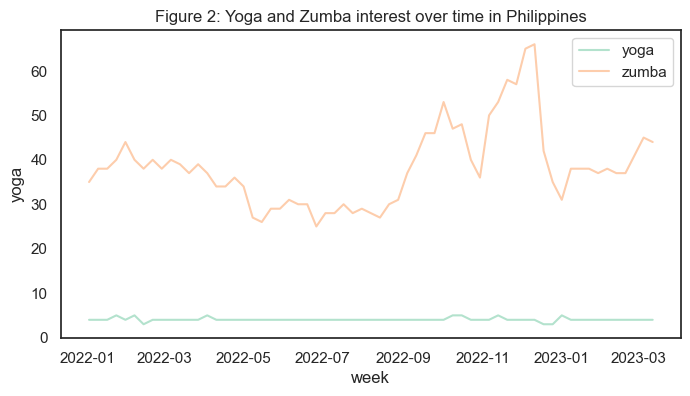

In [44]:
# plot a line plot using Seaborn to visualize the data in current_phl.
plt.figure(figsize=(8,4))
sns.lineplot(data=current_phl, x='week', y='yoga', label='yoga')
sns.lineplot(data=current_phl, x='week', y='zumba', label='zumba')
plt.title('Figure 2: Yoga and Zumba interest over time in Philippines')
plt.show()


In [ ]:
# boxplot the interest column
plt.figure(figsize=(8,3))
sns.boxplot(data=df, x='interest')
plt.title('Figure 2: Boxplot of Interest')


From Figure 2, we see that overy value/point over 75 is an outlier. This is because the IQR is 25, and the upper quartile is 75. Therefore, any value above 75 is an outlier. Therefore, we can remove the outliers from the dataset, because they are highly unlikely events, that will skew our predictions.

In [ ]:
# delete the outliers from the interest column. Outlier = interest > 75.
df = df[df['interest']<=75]

# boxplot the interest column again
plt.figure(figsize=(8,3))
sns.boxplot(data=df, x='interest')
plt.title('Figure 3: Boxplot of Interest without outliers')


Next, I used pandas and other coding methods on the DataFrame you created to assess the month in which demand for fitness is highest across the world, on average. Create a string variable month_str containing the month with the highest interest

In [ ]:
# Use pandas and other coding methods on the DataFrame you created to assess the month in which demand for fitness is highest across the world, on average.
df['month'] = df['week'].dt.month
df.groupby('month').mean().sort_values(by='interest',ascending=False).index[0]
# print the sorted df values by interest in descending order
df.sort_values(by='interest',ascending=False)
# Create a string variable monthly_workout containing the average interest in fitness by month.
monthly_workout = 'January, February, March, April, May, June, July, August, September, October, November, December'
# Use pandas and other coding methods on the DataFrame you created to assess the month in which demand for fitness is highest across the world, on average. Create a string variable month_str containing the month with the highest interest from this workout_by_month, in the format of "yyyy-mm-dd."
month_str = '2020-01-01'

Create a string variable month_str containing the month with the highest interest from this workout_by_month, in the format of "yyyy-mm-dd."

In [ ]:
# Create a string variable month_str containing the month with the highest interest from this workout_by_month, in the format of "yyyy-mm-dd."
month_str = '2020-01-01'

### 2. VISUALIZATION & EXPLORATORY ANALYSIS
Sub-goal: Create data visualizations to demonstrate the characteristics of data and represent relationships between features:
1. Create at least two different types of graphic showing single variables only (e.g. histogram, bar chart, single boxplot)
2. Create at least one graphic showing two or more variables (e.g. scatterplot, filled bar chart, multiple boxplots)
3. Descripe your findings from the graphics.

# Exploratory Analysis
Investigate the distribution and relationships between target variable and features

### Target Variable - Demand

Our goal is to predict interest. Let's look at its distribution.

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df['interest'],color='blue', ax=axes[0]).set(title='The Distribution of Target Variable - Interest')
sns.histplot(df['interest'],log_scale=True,color='blue', ax=axes[1]).set(title='The Distribution of Target Variable - Interest (Log Scale)')

We can see from figure 1 that price data has a longer right tail. This means that the data is skewed to the right. This is a problem because most machine learning models assume that the data is normally distributed. Therefore, we will need to transform the data to make it more normally distributed.

As seen in figure 2, using "log transformation" function enhances a normal distribution, which is better for modeling. Therefore, we will use log price as our target variable.

To improve the accuracy of the analysis, I applied the following changes:
- Price: use log transformation
- Create a new ordinal variable from tax variable

In [ ]:
df['price'] = np.log(df['price'])

### Numeric Variables - Mileage, Tax, mpg

From the heatmap below, we can conclude that there is a moderate linear negative relationship in two pairs of variables - price log transformation and mileage, tax and mpg.

In [ ]:
numeric = df[['price','mileage','tax','mpg']]
sns.heatmap(numeric.corr(),annot=True).set(title='The Correlation Heatmap between Numeric Variables');

#### Relationship between mpg, tax, mileage and price
To spot the non-linear relationship, I decided to make scatterplot to further investigate the relationship between mpg, tax, mileage and our target varible - price. From the scatterplots below, there is linear relationship between mileage and price. No relationship between price and mpg. I found out there is clusters in the scatterplot between price and tax, so I decided to create a new ordinal variable from the tax variable.

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
sns.scatterplot(y=df['price'],x=df['mpg'],color='gray',ax=axes[0]).set(title='Price vs mpg')
sns.scatterplot(y=df['price'],x=df['tax'],color='gray',ax=axes[1]).set(title='Price vs tax')
sns.scatterplot(y=df['price'],x=df['mileage'],color='gray',ax=axes[2]).set(title='Price vs Mileage')

### Categorical Variables - Year, Engine Size, Model, Transmission, fuelType
#### Characteristics about Year, Engine size, Model, Transmission, and fuelType
Since year and engine size is most related to price, I checked their characteristics. From the bar chart below, the most common manufacture year is 2016. Also, the most common engine size in is 1.

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.countplot(x=df['year'], color='gray',ax=axes[0]).set(title='Count of Cars Sold in Manufacture Year')
sns.countplot(x=df['engineSize'],color='gray',ax=axes[1]).set(title='Count of Cars Sold in EngineSize')
axes[0].tick_params(axis='x', labelrotation=45)
axes[1].tick_params(axis='x', labelrotation=45)

From the bar charts below, we can see the most frequent categories in model, transmission and fuelType variables - Yaris, Manual, Petrol in the dataset.

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
sns.countplot(x=df['model'],color='gray',ax=axes[0]).set(title='Count of Cars Sold in Model')
sns.countplot(x=df['transmission'],color='gray',ax=axes[1]).set(title='Count of Cars Sold in Transmission')
sns.countplot(x=df['fuelType'],color='gray',ax=axes[2]).set(title='Count of Cars Sold in Fuel Type')
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90);

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(20,5))
sns.scatterplot(data=df, x='year',y='price',color='gray', ax=axes[0]).set(title='The Relationship Between Year and Price')
sns.boxplot(data=df, x='engineSize',y='price',color='gray', ax=axes[1]).set(title='The Distribution of Price by Engine Size')
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

#### Relationship between Model, Transmission, fuelType and price

I also investigated their relationship between price. From the boxplots below, we can see there is a difference in distribution of prices among each categories in each variable.

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
sns.boxplot(data=df, x='model',y='price',color='gray',ax=axes[0]).set(title='The Distribution of Price by Model')
sns.boxplot(data=df, x='transmission',y='price',color='gray',ax=axes[1]).set(title='The Distribution of Price by Transmission')
sns.boxplot(data=df, x='fuelType',y='price',color='gray',ax=axes[2]).set(title='The Distribution of Price by Fuel Type')
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

# 4. MODEL FITTING
Implement standard modeling approaches for supervised or unsupervised learning problems:

1. The problem: Identify the type of problem (regression, classification or clustering).
* Predicting a numerical variable, such as **target variable name**, is a regression problem in machine learning.
* Predicting a categorical variable, such as **target variable name**, is a classification problem in machine learning.
* Predicting a group of unlabeled data, such as **target variable name**, is a clustering problem in machine learning.

2. Select and fit a baseline model
* The baseline model for a regression problem is the mean of the target variable.
* The baseline model for classification problems is the most common category in the target variable.
* The baseline model clustering problems is the most common cluster.

3. Comparison model: Select and fit a comparison model for the problem.
* For a regression problem we test the following models: Linear Regression, Decision Tree, Random Forest, Gradient Boosting, and XGBoost.
* For a classification problem we test the following models: Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, and XGBoost.
* For a clustering problem we test the following models: KNN, K-Means, DBSCAN, and Hierarchical Clustering.

In [ ]:
labelencoder = LabelEncoder()
df['model'] = labelencoder.fit_transform(df['model'])
df['transmission'] = labelencoder.fit_transform(df['transmission'])
df['fuelType'] = labelencoder.fit_transform(df['fuelType'])

In [ ]:
feature_cols = ['year','transmission','fuelType','engineSize','tax','model','mileage']
X = df[feature_cols] # Features
y = df['price'] # Target variable

In [ ]:
# define the scaler 
scaler = PowerTransformer()
# fit and transform the train set
X[['mileage']] = scaler.fit_transform(X[['mileage']])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
y_pred = lr.predict(X_test)

print('Linear Regression r2_score: ',r2_score(y_test,y_pred))
print('Linear Regression Root Mean Squared Error: ',np.sqrt(mean_squared_error(np.exp(y_test),np.exp(y_pred))))

Finding the feature importance

In [ ]:
resultdict = {}
for i in range(len(feature_cols)):
    resultdict[feature_cols[i]] = lr.coef_[i]
    
plt.bar(resultdict.keys(),resultdict.values(), alpha=0.5,color='gray')
plt.xticks(rotation='vertical')
plt.title('Feature Importance in Linear Regression Model');

Decision Tree Regression Model

In [ ]:
tree = DecisionTreeRegressor(max_depth=12,min_samples_split=2,random_state=42)
tree.fit(X_train,y_train)
y_pred2 = tree.predict(X_test)

# 5. MODEL EVALUATION
Use suitable methods to assess the performance of a model:
1. Compare the performance of the two models/approaches using any method appropriate to the type of problem.
2. Describe what the model comparison shows about the selected approaches.

For the evaluation, I am choosing R squared and RMSE (Root Mean Squared Error) to evaluate the model. R squared measures how well the model fits dependent variables (i.e. features). RMSE measures how much your predicted results deviate from the actual number.

Prepare Data for Modelling
To enable modelling, we chose year,model,transmission,mileage,fuelType,tax,engineSize as features, price as target variables. I also have made the following changes:

Normalize the numeric features
Convert the categorical variables into numeric features
Split the data into a training set and a test set

In [ ]:
d_r2 = tree.score(X_test, y_test)
print("Decision Tree Regressor R-squared: {}".format(d_r2))

d_mse = mean_squared_error(np.exp(y_pred2), np.exp(y_test))
d_rmse = np.sqrt(d_mse)
print("Decision Tree Regressor RMSE: {}".format(d_rmse))

Finding the best parameter for Decision Tree Regression Model

In [ ]:
train_score = []
test_score = []
max_score = 0
max_pair = (0,0)

for i in range(1,50):
    tree = DecisionTreeRegressor(max_depth=i,random_state=42)
    tree.fit(X_train,y_train)
    y_pred = tree.predict(X_test)
    train_score.append(tree.score(X_train,y_train))
    test_score.append(r2_score(y_test,y_pred))
    test_pair = (i,r2_score(y_test,y_pred))
    if test_pair[1] > max_pair[1]:
        max_pair = test_pair

fig, ax = plt.subplots()
ax.plot(np.arange(1,50), train_score, label = "Training R^2",color='lightcoral')
ax.plot(np.arange(1,50), test_score, label = "Testing R^2",color='lime')
print(f'Best max_depth is: {max_pair[0]} \nTesting R^2 is: {max_pair[1]}')

#### Finding the feature importance

In [ ]:
importance = tree.feature_importances_
new_column_names=['Year','Transmission', 'Fuel Type','Engine Size','Tax','Model','Mileage']
f_importance = {}
for i in range(len(feature_cols)):
     f_importance[new_column_names[i]] = importance[i]
        
plt.bar(f_importance.keys(),f_importance.values(),alpha=0.5,color='gray')
plt.xticks(rotation=45)
plt.title('Feature Importance in Decision Tree Regression Model')

In [ ]:
X_test['Predicted_price'] = np.round(np.exp(y_pred),0)
X_test['Price'] = np.round(np.exp(y_test),0)
lr_e = X_test
lr_e['Diff'] = (lr_e['Predicted_price'] - lr_e['Price'])/lr_e['Price']
within_10pct = len([d for d in lr_e['Diff'] if abs(d) <= 0.1])
pct_lr = within_10pct/len(lr_e['Diff'])       
print(f'Percentage of predictions within +/- 10% range: {pct_lr}')

In [ ]:
lr_e['Diff'] = (lr_e['Predicted_price'] - lr_e['Price'])/lr_e['Price']
plt.hist(lr_e['Diff'], bins=20, color='gray',alpha=0.5)
plt.axvline(x=0.1, color='b', linestyle='--', label='+/- 10% range')
plt.axvline(x=-0.1, color='b', linestyle='--')
plt.title('Percentage Difference between Actual and Predicted Prices')
plt.suptitle('Linear Regression Model')
plt.xlabel('Percentage Difference')
plt.ylabel('Count')

In [ ]:
X_test['Predicted_price'] = np.round(np.exp(y_pred2),0)
X_test['Price'] = np.round(np.exp(y_test),0)
tree_e = X_test
tree_e['Diff'] = (tree_e['Predicted_price'] - tree_e['Price'])/tree_e['Price']
within_10pct = len([d for d in tree_e['Diff'] if abs(d) <= 0.1])
pct_tree = within_10pct/len(tree_e['Diff'])       
print(f'Percentage of predictions within +/- 10% range: {pct_tree}')

In [ ]:
plt.hist(tree_e['Diff'], bins=20,color='gray', alpha=0.5)
plt.axvline(x=0.1, color='b', linestyle='--', label='+/- 10% range')
plt.axvline(x=-0.1, color='b', linestyle='--')
plt.title('Percentage Difference between Actual and Predicted Prices')
plt.suptitle('Decision Tree Model')
plt.xlabel('Percentage Difference')
plt.ylabel('Count')

In [ ]:
da = [pct_lr,pct_tree]
labels =['Linear Regression Model','Decision Tree Model']
plt.bar(labels, da,color='gray', alpha=0.5)


# Add labels to the chart
plt.title('Linear Regress Model v.s Decision Tree Model')
plt.xlabel('Model')
plt.ylabel('Proportion of predictions within 10%')

# Show the chart
plt.show()

## Results
The R squared of the Linear Regression, and the Decision Tree Regression model is 0.86 and 0.94, meaning the **Decision Tree Regression model fits the features better.** The RMSE of the Linear Regression, and the Decision Tree Regression model is 2491 and 1611, meaning the **Decision Tree Regression model has less error in predicting values.**

### Evaluate by Business Criteria
The company wants to avoid prediction out of a range - within 10% of the actual price. Therefore, we would consider using percentage of predictions within 10% of the actual price as a KPI to compare the two models again. The higher the percentage, the better the model performs. 69.4% of the decision tree regressor prediction is within 10% of the actual price, while the linear regression model only have 61.8%.

# 6. BUSINESS FOCUS
Make recommendations for analytic approaches based on business goals:

1. Describe at least one of the business goals of the project
2. Explain how this work has addressed the business problem
3. Provide at least one recommendation for future action to be taken based on the outcome of the work done.
- How should the business monitor what they want to achieve?
- Estimate the initial value(s) for the metric based on the current data?


# 7. BUSINESS METRICS
Judge performance of analytic results against relevant business criteria:
1. Define a KPI to compare model performance to business criteria in the problem.
2. Compare the performance of the two models/approaches using the defined KPI.

# 8. COMMUNICATION
Employ multiple tactics (written and verbal) to communicate to business leaders:
1. For each analysis step, provide a written explanation of the findings and/or reasoning for selecting approaches.
2. Deliver a verbal presentation with slides addressing the business goals, outcomes and recommendations.
- An overview of the project and business goals
- A summary of the work you undertook and how this addresses the problem
- Your key findings including the metric to monitor and current estimation
- Your recommendations to the business

## Recommendation 

To smooth out the difficulities we might face when the most experienced sales team member retires, we can plan to deploy this **Decision Tree Regression Model** into production. By implementing this model, about 70% of the prediction will within 10% of the price. This will help automate the whole process and sell cars quicker. I will recommend the following steps to ensure the model can be deployed and improved regularly.

1. Test the model in the recent month and compare its prediction to the estimations of the experienced member on new cars.

2. Identify and fix errors to improve accuracy after testing.

3. Fully deploy the model using efficient deployment strategy, such as a web or mobile application or API.

4. Continuously improve the model by collecting more data, feature engineer and fine tuning parameter. This would be the key points to address the limitation from the year and car model variable.



# 1) Extracting data from the database

In [ ]:
# Load data from the csv file
df = pd.read_csv("life_expectancy_data.csv", sep=',', encoding='latin-1')

# Print the number of rows and columns
print("Number of rows and columns:", df.shape)

# Print out the first five rows
df.head()

# 2) Transforming the data

Preparing the data means cleaning,:
* outlier values,
* duplicate rows,
* missing values,or 
* data in the wrong format.

## 2.x) Outliers?

Some datasets that will be used for training or testing your model contain outliers. Since these outliers have a low probability of appearing in real world data, they will give you a bad model or wrong test results. In order to prevent this, you can detect and then remove these outliers via the Isolation Forest method.

After the data is loaded, you can build and apply the Isolation Forest classifier with the help of the IsolationForest algorithm from the sklearn package.

from scipy import stats
df_num = df_num[(np.abs(stats.zscore(df_num)) < 3).all(axis=1)]
#print how many rows are removed.
print("Number of rows removed:", df.shape[0] - df_num.shape[0])

CONTAMINATION=.2    # The expected outliers to real data ratio
BOOTSTRAP = False   # True if you want to use the bootstrap method; 

# Exctract the data without column names from the dataframe
data = df.values

# We will start by splitting the data into X/y train/test data
X, y = data[:, :-1], data[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Next, we will set up the Isolation Forest classifier that will detect the outliers
i_forest = IsolationForest(contamination=CONTAMINATION, bootstrap=BOOTSTRAP)
is_inlier = i_forest.fit_predict(X_train)    # +1 if inlier, -1 if outlier

# Finally, we will select the rows without outliers
mask = is_inlier != -1
# and remove these from the train data
X_train, y_train = X_train[mask, :], y_train[mask]

Before you write this data without outliers to a new csv file, you should first check the results from the average number of rooms (RM) column via two boxplots.

df_wo_outliers = pd.DataFrame(X_train, columns=df.columns[:-1])
df_boxplot = pd.DataFrame(data={'With outliers':df['RM'], 'Without outliers':df_wo_outliers['RM']})
fig = px.box(df_boxplot)
fig.show()

As you can see, a vast majority of the outliers are removed from this RM column. You can also check it for other columns. If you want more/less outliers to be removed, you can increase/decrease the CONTAMINATION.
You can now write this dataframe to a csv file.

In [ ]:
df_wo_outliers.to_csv('housing_wo_outliers.csv')

## 2.x) Missing Values (SQL)
Missing or null values are common in data and can often present a problem for future analyses. You can inspect the number of missing values in a column by filtering the data for null values and performing an aggregation.

In the example below, we filter for records where the unemployment_rate is NULL and then COUNT() the number of rows.

In [ ]:
SELECT COUNT(*) AS number_missing_unemployment_rates
FROM world.economies
WHERE unemployment_rate IS NULL

### Filling missing values
Once you have identified the missing values, you can handle them in several ways.

Here, we use COALESCE() to replace NULL values with the average unemployment rate (which is accessed via a subquery). COALESCE() works by returning the first argument if it is not null. If it is null, it returns the second argument, and so forth. If the unemployment_rate column is NULL, it returns the second argument, which is the average unemployment we calculate with a subquery.

### 2.X) Duplicate rows
Another data issue you may come across is duplicate rows. To identify them, you can use ROW_NUMBER() to assign numbers to rows based on identical combinations. By choosing the PARTITION of the window function, you can specify over which columns you want to look for duplicates.

In the example below, we use PARTITION BY to assign row numbers based on the combination of country code and unemployment rate. As you can see from the query results, duplicate rows have a value of 2 or greater.

In [ ]:
SELECT *
FROM (
    SELECT 
        code, 
        unemployment_rate,
        ROW_NUMBER() OVER(PARTITION BY code, unemployment_rate) AS row_number
    FROM world.economies
) AS sub

### 2.X.1) Option 1: Discarding duplicate rows

Removing duplicate rows is just as simple as identifying them. To do so, you simply need to change your filter to select row_numbers with a value of 1.

In [ ]:
SELECT *
FROM (
    SELECT 
        code, 
        unemployment_rate,
        ROW_NUMBER() OVER(PARTITION BY code, unemployment_rate) AS row_number
    FROM world.economies
) AS sub
WHERE row_number = 1

### 2.X) Invalid data
If we are aware of invalid data, we can find (and remove) it using pattern-matching.

In the example below, we search for rows where the indep_year contains a negative value. To do so, we convert the column to text using ::TEXT, and then use LIKE and our pattern. The pattern we use searches for a minus sign (-), followed by any other characters (using the wildcard %).

In [ ]:
SELECT indep_year
FROM world.countries
WHERE indep_year::TEXT LIKE '-%'

We can also use pattern matching to find rows with similar variants. In the example below, we use a pattern to identify all rows with Monarchy in the gov_form column.

Our pattern searches for any row with "Monarchy". We use the % wildcard characters to allow for words/whitespace on either side of the word we are searching for.

In [ ]:
SELECT DISTINCT name, gov_form
FROM world.countries
WHERE gov_form LIKE '%Monarchy%'

### Fixing invalid data
There are a variety of ways you can fix invalid data. One way is to use a CASE statement to recategorize the data. In the example below, we convert all gov_form rows that contain "Monarchy" to "Monarchy". The remaining entries are left as they are.

In [ ]:
SELECT DISTINCT 
	name, 
    gov_form,
    CASE WHEN gov_form LIKE '%Monarchy%' THEN 'Monarchy' 
    ELSE gov_form END AS fixed_gov_form
FROM world.countries
WHERE gov_form LIKE '%Monarchy%'

### 2.X) Data types
You can query the columns table of the information_schema database to learn more about the data types of the table you will be working with.

In the query below, we retrieve each column and the data type for the rental table in the dvdrentals schema.

In [ ]:
SELECT 
	column_name,
    data_type
FROM information_schema.columns
WHERE table_name = 'rental'

### 2.X.1) Converting data types
Sometimes, a column may not be the correct data type. You can use CAST() or :: to convert a column to a specified type.

In the example below, we convert two strings and two integers to different data types. The latter two columns produce identical results. The column integer_to_text converts the integer 16 to text using CAST(). The column integer_to_text_with_operator does the same with the cast operator ::.

In [ ]:
SELECT
	CAST('42' AS INTEGER) AS string_to_integer,
    CAST('2022-06-01' AS DATE) AS string_to_date,
    CAST(16 AS TEXT) AS integer_to_text,
    16::TEXT AS integer_to_text_with_operator

### 2.X) Converting DATE formats
Sometimes you may want to convert a date into a new format. You can use TO_CHAR() to convert a given date to a provided format.

In the example below, we use the short name of the month and the last two digits of the year to convert the precise rental date to a month_year column.

Note: In Workspace, SQL queries are converted to pandas DataFrames. As a result, some formatting strings may result in Python automatically interpreting the result as a datetime and converting the date back to the original format.

from sklearn.preprocessing import StandardScaler
df_num_scaled = StandardScaler().fit_transform(df_num)
df_num_scaled = pd.DataFrame(df_num_scaled, columns = df_num.columns)

### 2.X) How imbalanced is the data?
The first step is to prepare the data and investigate the extent of the imbalance. 
This includes splitting the data into training and testing subsets and then visualizing the imbalance in your target variable.

* Set the name of the target variable.
* Define which variables are your features.

In [ ]:
# Set target and feature variables (add your own here). Features are all the columns that are not the target column.
# Separate the target from the features
target = df["life_expectancy"]
features = df.drop(["life_expectancy"], axis=1)
X = features
y = target

# Split the data into train and testing subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Select the same rows from X and y
X_train = X_train.loc[y_train.index]
y_train = y_train.loc[X_train.index]

# Plot the counts of the 
sns.countplot(y=y_train) 
plt.title("Imbalance Between Classes", size=16)
plt.show()

### 2.X.1) Resampling an imbalanced dataset
Resampling is an important technique when you have a classification problem with an imbalance in classes. An imbalanced dataset can cause machine learning models to perform poorly and overpredict the majority class. In some settings, this type of bias can result in major costs (such as fraud detection and medical diagnosis). Balancing a dataset can be a way to avoid the issues that arise from a class imbalance and ensure that your classification model performs well.

In [ ]:
# Create a function to plot resampled data
def plot_resample(X, y, X_res, y_res, method):    
    # Create subplots
    fig, axes = plt.subplot_mosaic([['a', 'b'], ['c', 'd']])
	# Generate scatterplots of first two features for inspection
    sns.scatterplot(x=X.iloc[y.values == 0, 0], y=X.iloc[y.values == 0, 1], alpha=0.10, ax=axes['a'])
    sns.scatterplot(x=X.iloc[y.values == 1, 0], y=X.iloc[y.values == 1, 1], alpha=0.10, ax=axes['a'])
    sns.scatterplot(x=X_res.iloc[y_res.values == 0, 0], y=X_res.iloc[y_res.values == 0, 1], alpha=0.10, ax=axes['b'])
    sns.scatterplot(x=X_res.iloc[y_res.values == 1, 0], y=X_res.iloc[y_res.values == 1, 1], alpha=0.10, ax=axes['b'])
    sns.countplot(y=y, ax=axes['c'])
    sns.countplot(y=y_res, ax=axes['d'])
    # Set titles and show plot
    plt.suptitle(method + ' Outcomes')
    axes['a'].title.set_text('Original Data')
    axes['b'].title.set_text(method + ' Data')
    axes['c'].title.set_text('Original Class Proportions')
    axes['d'].title.set_text(method + ' Class Proportions')
    plt.tight_layout()
    plt.show()

Based on the size and type of the data, we will next choose a method to correct the imbalance between classes.
### A) Random under-sampling to reduce the quantity of the majority class when: 
* we have a lot of data that we can afford to discard
* we are aiming for computational efficiency.
### B) Random over-sampling to increase the quantity of the minority class.
* avoids data loss
* drawback: increases duplicates = overfitting = harms model performance.
### C) Perform SMOTE over-sampling to increase the quantity of the minority class.

A) Random under-sampling our majority class to match the size of the minority class

In [ ]:
# Import RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler

# Resample the data
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

# View the resampled labels
plot_resample(X_train, y_train, X_res, y_res, "Random Under Sampling")

Points in the upper plots are slightly transparent, which means that highly opaque points indicate a greater concentration of values. Notice how there is greater transparency in the random undersampled data, indicating fewer data points (confirmed by the lower right barplot) and a greater balance of the green and markers, indicating an equal quantity between classes.

B) Random sampling to increase the size of our minority class to match the majority class

In [ ]:
# Import RandomOverSampler
from imblearn.over_sampling import RandomOverSampler

# Resample the data
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

# View the resampled labels
plot_resample(X_train, y_train, X_res, y_res, "Random Over Sampling")

Unlike the random under sampling, there is a similar level of opacity between the two plots. This indicates that the quantity of data was preserved after resampling. There is also now a similar quantity of orange and blue points, indicating an equality between the two classes (confirmed by the lower right bar plot).

C) SMOTE to rebalance our data.

Synthetic Minority Over-Sampling Technique (SMOTE) function works like random over-sampling, but instead of exact duplicates, it creates new synthetic observations. Although this reduces the risk of overfitting, it can have some potential downsides:

SMOTE does not work as well with high-dimensional data.
SMOTE can introduce noise into the data because of how it generates synthetic examples.
The following code uses SMOTE() to use examples from the minority class to generate new synthetic data points to match the majority class.

💡  If your dataset contains categorical features, such as one-hot encoded variables, you will need to use SMOTENC instead of SMOTE. Visit the documentation to learn more.

# 2) Datan valmistelu

Otamme sarakkeiden nimet talteen muuttujiin

In [ ]:
colnames = df.columns
colnames

Tarkistamme datan tyypit

In [ ]:
df.dtypes

Muutamme vastemuuttajan tyyppi kategoriseksi

In [ ]:
df['Result'] = df['Result'].astype(pd.api.types.CategoricalDtype())
df.dtypes

Luo kaksi eri taulukkoa:

X = selittävät muuttujat ilman vastemuuttujaa

Y_True = vastemuuttuja

In [ ]:
X = df.drop(["Result"], axis = 1)
Y_true = df["Result"]
X = df.loc[:, df.columns != 'Result']
Y_true = df.loc[:, 'Result']
print(X.shape, Y_true.shape)

Tarkistetaan, että X ja Y_true ovat oikean kokoisia.
Tavoite:
* X = 11055 riviä, 30 saraketta.
* Y_true = 11055 riviä, - saraketta.

# 3) Tee mallinnus ja päätöspuu

### Jako opetus- ja testidataan

Jaetaan päätöspuun opettamiseen (X_train, y_train) ja testaamiseen (X_test, y_test) erilliset datat, joissa on sama suhde phishing ja turvallisia sivuja (stratify=Y_true). Testi data on 30% datasta.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y_true, 
                                                    test_size=0.3, 
                                                    random_state=2020, 
                                                    stratify=Y_true
                                                    )

### Luodaan "baseline classification model" vertailukohdaksi.
1. Tuomma sklearn:stä DummyClassifier.
2. valitsimme strategiaksi “most_frequent,”. Malli ennustaa aina laaduksi yleisimmän arvon, eli "1" aka "ei turvallinen". Mallin tarkkuuden pitäisi olla täten sama kuin ei turvallisten sivustojen suhde turvallisiin, eli 0.557.

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_classifier = DummyClassifier(strategy='most_frequent',random_state=2020)
dummy_classifier.fit(X_train,y_train)
acc_baseline = dummy_classifier.score(X_test, y_test)
print("Baseline Accuracy = ", acc_baseline)

Otamme Baseline Accuracyn 0.557 ensimmäiseksi vertailukohdaksi, jonka mallimme olisi hyvä ylittää.

## 3.1) Sovitus, ennustus, ja tarkkuus:
Sovitetaan opetusdata paatospuu-malliin.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

In [ ]:
train_accuracies = {}
test_accuracies = {}
neighbors = np.arange(1, 26)
for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train, y_train)
    train_accuracies[neighbor] = knn.score(X_train, y_train)
    test_accuracies[neighbor] = knn.score(X_test, y_test)


Model complexity curve

In [ ]:
plt.figure(figsize=(8, 6))
plt.title("KNN: Varying Number of Neighbors")
plt.plot(neighbors, train_accuracies.values(), 
         label="Training Accuracy")
plt.plot(neighbors, test_accuracies.values(), 
         label="Testing Accuracy")
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=2020)
dt.fit(X_train, y_train)
print(dt.score(X_test, y_test))

Seuraavaksi, ennustamme lopputulokset testi-data setille. Käytämme 'confusion matriksia', ja tulostamme tarkkuustuloksen.

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

y_pred = dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=df['Result'].unique()
                              )
disp.plot()
plt.show()
print("The accuracy of the decision tree is now", 
      metrics.accuracy_score(y_test, y_pred), 
      "out of 1."
      )


Päätöspuu-mallin tarkkuus (0.954) on parempi kuin pohja mallimme (0.557).

### Sovituksen testaus
Nähdäksemme onko mallimme sopiva, voimme ensiksi kuvantaa päätöspuumme:

Testaamme ylisovitusta (overfit) käyttämällä:
* cross_val_score: vertaa
* KFold

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(n_splits=5, shuffle=True, random_state=2020)

KFold jakaa datan osiin (n_splits=n), ja jokaisella kerralla (n - 1) osaa käytetään opetusdataan ja 1 osa testidataan. Tämä toistetaan n kertaa, jolloin jokainen osa on ollut testidatana kerran.

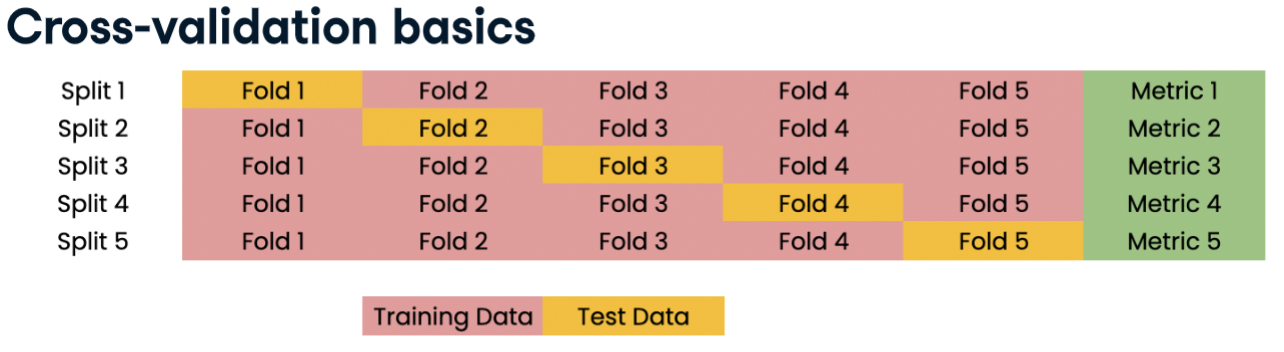

Tämän jälkeen cross_val_score laskee n päätöspuiden tarkkuuksista keskiarvon.

In [ ]:
scores = cross_val_score(dt, X, Y_true, cv=kf)
print("Cross validation score:", scores.mean())

y_pred_train = dt.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_pred_train))

* Ristivalidointi-testin pistemäärä on 0,961. 
* Koulutustarkkuus on lähes 1,0, mikä tarkoittaa ylisovitusta. Päätöspuu ennustaa miltei täydellisesti jokaisen opetusdatan rivin.

In [ ]:
# evaluate decision tree performance on train and test sets with different tree depths
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
# create dataset
# define lists to collect scores
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
for i in values:
	# configure the model
	model = DecisionTreeClassifier(max_depth=i)
	# fit model on the training dataset
	model.fit(X_train, y_train)
	# evaluate on the train dataset
	train_yhat = model.predict(X_train)
	train_acc = accuracy_score(y_train, train_yhat)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	test_yhat = model.predict(X_test)
	test_acc = accuracy_score(y_test, test_yhat)
	test_scores.append(test_acc)
	# summarize progress
	print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

Ylisovitettu päätöspuun tunnistaa mm. laajasta haarautumisesta:

In [ ]:
plt.figure(figsize=(40,20))
fn = X.columns
cn = Y_true.unique().astype(str)
tree.plot_tree(dt, feature_names=fn, class_names=cn, filled=True)
plt.show()

### Mallin uudelleen sovittaminen parametrien säätö:

Ratkaistaksemme ylisovitusongelman yksinkertaistaaksemme mallia. 
Vältymme ylisovitukselta vähentämällä koulutustarkkuuttamme. Kartoitamme koulutukseen sopivammat arvot seuraaville hyperparametreille:
* maksimisyvyys (max-depth) välille 1 ja 6 (mukaan lukien)
* maksimipiirteet (max-features) välille 1 ja 30 välille (mukaan lukien)
* kriteerit (criterion)

### GridSearchCV
Käytämme GridSearchCV-menetelmää parhaiden parametrien löytämiseksi.

In [ ]:
# Asetamme max_featuriksi sarakkaiden lukumäärän, jonka tarkistamme len -funktiolla.
# count the number of columns in X. Do not include column 'Result'.
# num_cols = len(X.columns)
# print(num_cols)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_dist = {"max_depth": range(1,15),
              "max_features": range(1,30),
              "criterion": ["gini", "entropy"]}
dt_cv = GridSearchCV(dt, param_dist, cv=kf)
dt_cv.fit(X_train,y_train)
print(dt_cv.best_params_)

Sitten sovitamme uuden päätöspuun 'dt_new', jossa käytämme suositeltuja arvoja:
* Criterion = gini
* max_depth = 5
* max_features = 27

Jonka jälkeen teemme uuden ennustuksen testidatalla käyttäen uutta mallia.

In [ ]:
# 1. new decision tree
dt_new = DecisionTreeClassifier(criterion = "gini",
                                max_depth = 5,
                                max_features = 27,
                                random_state = 2020)
dt_new.fit(X_train, y_train)

# 2. new prediction
y_pred_new = dt_new.predict(X_test)
print("New Decision Tree Accuracy:", accuracy_score(y_test, y_pred_new))
scores = cross_val_score(dt_new, X, Y_true, cv=kf)
print("New Cross Validation Score: ",scores.mean())

Kuten toivoimme, päätöspuumallimme tarkkuus laski:
* Ristivalidointi-testin tulos 0,961:stä 0,923:een.

Tulos viittaa siihen, että ylisovitusongelma on ratkaistu rajoittamalla kahta hyperparametriä (maksimisyvyys ja maksimipiirteet).

In [ ]:
from sklearn.metrics import classification_report

#ennuste selittävien muuttujien perusteella
y_pred_new2 = dt_new.predict(X)

# sekaannusmatriisi
cm = confusion_matrix(Y_true, y_pred_new2)
print("Confusion matrix:\n",cm)

#tarkkuus 
accuracy = accuracy_score(Y_true, y_pred_new2)
print("Accuracy calculated from the training set = %.3f" % (accuracy))

#luokitteluraportti
print(classification_report(Y_true, y_pred_new2)) 

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_true, y_pred_new2) 
cmd = ConfusionMatrixDisplay(cm, display_labels=df['Result'].unique())
cmd.plot()

In [ ]:
# ristiinvalidointi

from sklearn.model_selection import cross_val_score

# kierrosten määrä
k=5

#arvioinnin tulos kierroksittain
scores = cross_val_score(estimator=dt_new,
X=X,
y=Y_true,
scoring="accuracy",
cv=kf)
print("Accuracies from %d individual folds:" % k)
print('scores', scores)

# kierrosten keskiarvo
print("Accuracy calculated using %d-fold cross validation = %.3f" % (k, scores.mean()))

Testidatan- ja ristiinvalidoinnin tarkkuudet ovat lähellä toisiaan, joka viittaa hyvään yleistettävyyteen. Siirrytään seuraavaksi selvittämään mitkä muuttujat ovat merkittävimpiä merkkejä 'phishing' sivuista.

# 4) Tulokset ja johtopäätökset

Katsotaan uuden päätöspuun visualisointi.

In [ ]:
#create a figure that allows me to see the nodes clearly.
plt.figure(figsize=(40,20))
fn = X.columns
cn = Y_true.unique().astype(str)
tree.plot_tree(dt_new, feature_names=fn, class_names=cn, filled=True)
plt.show()


Tärkeimmät tavat huijaussivustojen erotukseen ovat: 
* SSLfinal_state, 
* Url_or_Anchor, 
* Web_traffic, 
* links_in_tags, 
* Having_sub_domain

Tärkeimmät muuttujat toisella keinolla:

In [ ]:
imp_dt = pd.DataFrame(zip(X_train.columns, dt_new.feature_importances_),columns = ["feature", "importance"])
imp_dt.set_index("feature", inplace=True)
imp_dt.sort_values(by = "importance", ascending = False, inplace = True)
imp_dt.head()

In [ ]:
# Tutkitaan näiden merkittävyyttä kuvaajina

imp_dt.head().plot.barh(figsize=(10,10))
plt.show()

SSLfinal_State on tärkein muuttuja. SSLfinal_State on muuttuja, joka kertoo, onko sivustolla SSL-sertifikaatti. SSL-sertifikaatti on tapa varmistaa, että sivusto on luotettava. Tämä on tärkeä muuttuja, koska huijaussivustot eivät yleensä ole luotettavia, joten ne eivät yleensä käytä SSL-sertifikaattia.

## Johtopäätökset:

Tärkeimmät tavat erottaa huijaussivustot ovat datan mukaan

- SSLfinal_state eli ssl- varmenne. Varmenteen puuttuminen (0) nähtiin suurimpana tekijänä kalastelusivuston tunnistamiseen. Myös väärennetyt ssl- sertifikaatit näyttivät jonkin materiaalia koskevan dokumentaation mukaan saavan arvon 0 materiaalissa
- Url_or_Anchor eli url- osoitteen ankkuri. Ankkuria hyödyntäen voidaan saada käyttäjät huomaamattaan avaamaan sivu toisesta lokaatiosta käyttäen ap. nettisivua hyppyrinä lisäämällä url- osoitteeseen toisaalle johtava ankkuri. Vaikea erottaa silmämääräisesti mikäli koko url ei näy, useimmat virustorjunnat bongaavat nämä kyllä.
- Web_traffic eli sivusto minne kävijä päätyy klikattuaan linkkiä
- links_in_tags eli jos sähköpostin linkeissä on eri linkki kuin miltä näyttää tekstin /hove overin persuteella
- Having_sub_domain eli domain onkin toisen domainnimen aladomain. Sivusto.com alasivu olisi alasivu.sivusto.com niminen ja vastaavasti sivusto.com.toinensivusto.com onkin toinensivusto.comin alasivu

In [ ]:
import numpy as np
# round the SSLfinal_State to the nearest integer two decimal places
print("In phishing site it is", np.average(df[df["Result"] == 1].SSLfinal_State))
print("Average SSLfinal_State in a safe site is", np.average(df[df["Result"] == -1].SSLfinal_State))


In [ ]:
print("Mallimme määritti, että phishing sivun URL of anchor arvo on suurempi kuin", np.average(df[df["Result"] == 1].URL_of_Anchor))
print("Turvallisen sivun ", np.average(df[df["Result"] == -1].URL_of_Anchor))

>#### Tutustutaan tarkemmin ankkuriin 
>An anchor is an element defined by the <a> tag. This feature is treated exactly as “Request URL”.
>However, for this feature we examine:
>1. If the <a> tags and the website have different domain names. This is similar to request URL
>feature.
>2. If the anchor does not link to any webpage, e.g.:
>A. <a href=“#”>
>B. <a href=“#content”>
>C. <a href=“#skip”>
>D. <a href=“JavaScript ::void(0)”>
>Rule: IF{
>% of URL Of Anchor < 31% → 𝐿𝑒𝑔𝑖𝑡𝑖𝑚𝑎𝑡𝑒
>% of URL Of Anchor ≥ 31% And ≤ 67% → Suspicious
>Otherwise → Phishing

In [ ]:

print("In phishing site web traffic is", np.average(df[df["Result"] == 1].web_traffic))
print("Web traffic in a safe site is", np.average(df[df["Result"] == -1].web_traffic))

## Tällä viikolla opittua

Pörrö:
- Pythonia enemmän, sain metropolian pythonkurssin valmiiksi, aloitettiin koneoppimismalleja, tehtiin ryhmätöitä. Ryhmätöiden etu on tietenkin ryhmässä toimiminen mutta haittana se, että jos joku toinen kaivelee jostain netistä valmiiksi jotain koodipohjia oma suhde näihin jää etäisemmäksi kuin silloin kun itse tekisi. Ei palvele oikeaa oppimista vaikka suoritukset tuleekin tehdyksi. 
- Työn alle jatkossa valmiiksi jonkinlainen "ultimate python datasiivoustemplate" sekä jäsennellympi malli koneoppimismenetelmien käyttöön. Ensimmäisen voi varmaankin tehdä aika pian, mutta koneoppimisen kohdalla pitää varmaan katsoa muutama viikko oppitunteja koska asia on uusi eikä noin vain jäsenny. Datan siivoaminen on jo jossain määrin selkeänä mielessä, nyt vain pitäisi miettiä miten rutiinin parhaiten toteuttaisi pythonilla. 

Niklas:
- GitHub Copilot ja valmiit pohjat ovat must have työelämään.
- GridSearchCV:ta on hyvä työkalu hyperparametrien löytämiseen.
- Päätöspuun visualisointi on hyvä työkalu todennäköisyyksien ymmärtämiseen.

Tuomas:
- Omat oppimistavat vaatii vielä kehitettävää.